# Entrenar un autoencoder basado en capas Convolucionales en Mnist

In [0]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import MaxPooling2D,UpSampling2D

from keras.models import Model
from keras.datasets import mnist
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# MNIST dataset
def load_data():
  (x_train, _), (x_test, _) = mnist.load_data()
  input_shape = (28,28,1)
  x_train = np.reshape(x_train, [-1, 28,28,1])/255.0
  x_test = np.reshape(x_test,   [-1, 28,28,1])/255.0
  return x_train,x_test,input_shape

def ConvolutionalAutoencoder(input_shape,filters):
  def generate_encoder():
    encoder_input = Input(shape=input_shape, name='encoder_input')
    
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(encoder_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    encoded_shape = K.int_shape(x)[1:]

    encoder = Model(encoder_input, x, name='encoder')
    return encoder,encoder_input,encoded_shape

  def generate_decoder(encoded_shape):
    latent_input = Input(shape=encoded_shape, name='decoder_input')

    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(latent_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_input, x, name='decoder')
    return decoder,latent_input

  encoder,encoder_input,encoded_shape = generate_encoder()
  decoder,latent_input = generate_decoder(encoded_shape)
  autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
  return autoencoder,encoder,decoder,encoded_shape


x_train,x_test,input_shape = load_data()
filters=8
autoencoder,encoder,decoder,encoded_shape=ConvolutionalAutoencoder(input_shape,filters)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

print(autoencoder.summary())
print(encoder.summary())
print(decoder.summary())

batch_size = 128
# Train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10,
                batch_size=batch_size)

# Predict the Autoencoder output from test images
x_decoded = autoencoder.predict(x_test)






Using TensorFlow backend.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 4, 4, 4)           520       
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         665       
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________
None
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
______________________________________________________________

# Mostrar imágenes antes y después de pasar por el modelo

---



Original
Decoded


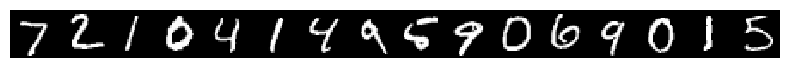

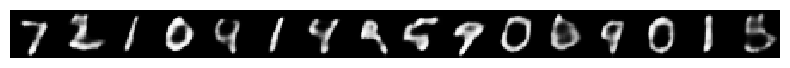

In [0]:



def show_as_single_image(imgs):

  n,h,w,c=imgs.shape
  imgs = imgs.reshape((n, h,w))
  imgs = imgs.swapaxes(1,2).reshape((n*w, h)).swapaxes(0,1)
  imgs = (imgs * 255).astype(np.uint8)

  plt.figure(figsize=(1*8,n*8),dpi=100)
  plt.axis('off')
  plt.imshow(imgs, interpolation='none', cmap='gray')
  plt.tight_layout()

num=16
print("Original")
show_as_single_image(x_test[:num])
print("Decoded")
show_as_single_image(x_decoded[:num])


# Intentar generar nuevas muestras desde el espacio latente (no funciona, necesito usar [Autoencoders variacionales](https://blog.keras.io/building-autoencoders-in-keras.html) or GANs)

(8, 28, 28, 1)


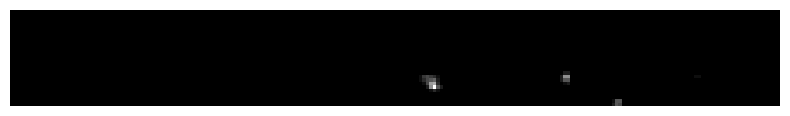

In [0]:

num_images=8
random_latent_code = np.random.random_sample([num_images,*encoded_shape])

random_images = decoder.predict(random_latent_code)

print(random_images.shape)
show_as_single_image(random_images)
